### Note: We need preprocessed texts (tokinized and numericalized) in this notebook

> Notebook based on:
> 1. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12_text.ipynb
> 2. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12a_awd_lstm.ipynb
> 3. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12b_lm_pretrain.ipynb
> 4. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12c_ulmfit.ipynb
> 
> Video:
> - https://youtu.be/vnOpEwmtFJ8?t=4687 from 1:18:00 to 2:08:00 (50 mins)

# Constants

In [1]:
BPTT_LEN   = 70 # Lengh of the minisequences in the big stream (used In Dataset)
BATCH_SIZE = 64 # (used In DataLoader)
PAD_TOKEN  = 1  # Number for xxPad token (used in the nn.Embedding layer of the Model)
VOCAB_LEN  = None # This will be updated when we read the vocab.pkl file (used in the nn.Embedding layer)

# Imports

In [2]:
import numpy as np
import pathlib
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Sampler, DataLoader

import fastai
print("Pytorch:", torch.__version__)
print("Fast.ai:", fastai.__version__)

Pytorch: 1.8.1
Fast.ai: 2.2.5


# Data

In [3]:
!ls "../../Datasets/NLP/IMBd_prepro"

test  train  unsup  vocab.pkl


In [4]:
!ls "../../Datasets/NLP/IMBd_prepro/train"

neg  pos


# Read vocab

In [5]:
vocab_file = open("../../Datasets/NLP/IMBd_prepro/vocab.pkl",'rb')
vocab = pickle.load(vocab_file)

In [6]:
VOCAB_LEN = len(vocab)
VOCAB_LEN

65539

In [7]:
def denumericalize(list_of_nums):
    return [vocab[i] for i in list_of_nums]

In [8]:
denumericalize( range(20) )

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'this']

# Utils

In [9]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

def parallel_map(func, array):
    
    cpu_cores = multiprocessing.cpu_count()
    array_len = len(array)
    chunksize = array_len // 100
    
    if cpu_cores<2:
        return list(tqdm(map(func, arr), total=array_len))
    else:
        with ProcessPoolExecutor(max_workers=cpu_cores) as ex:
            return list(tqdm(ex.map(func, array, chunksize=chunksize), total=array_len))

---
# <center> Dataset & Dataloader for Langauge Model
- X: Text
- Y: Same text but shifted by 1 token

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

# Dataset

In [10]:
class LM_Dataset(Dataset):
    
    def __init__(self, prepro_texts_dir, bptt=70, shuffle=False):
        
        # Read tokenized and numeralized text files (numpy format)
        np_filepaths = list( pathlib.Path(prepro_texts_dir).glob('**/*.npy') ) 
        
        # Open numpy arrays in parallel
        #self.texts_np = list(map(func=np.load, np_filepaths))  # Non parallel version   
        self.texts_np = parallel_map(func=np.load, array=np_filepaths)

        self.bptt    = bptt
        self.shuffle = shuffle
        self.total_tokens = sum([len(t) for t in self.texts_np])
        
        self.concat_texts_into_stream()
        
    # this is necesseary at the begining of every epoch for train !!!!
    def concat_texts_into_stream(self):
        
        # 1. Reorder texts if we need to
        if self.shuffle:
            np.random.shuffle(self.texts_np)
            #self.texts_np = self.texts_np[np.random.permutation(len(self.texts_np))]
            
        # 2. Concat texts into a large stream
        self.stream = np.concatenate(self.texts_np)
        #self.stream = torch.cat([torch.Tensor(t) for t in self.texts_np])
                
    def __len__(self):
        return self.total_tokens // self.bptt
    
    def __getitem__(self, idx):
        x = self.stream[idx   : idx+self.bptt]
        y = self.stream[idx+1 : idx+self.bptt+1] # shifted by 1
        
        # convert from numpy.uint16 to torch.int64        
        x = torch.tensor(x.astype("int64"))
        y = torch.tensor(y.astype("int64"))
        
        return x,y

In [11]:
train_ds = LM_Dataset("../../Datasets/NLP/IMBd_prepro/train", bptt=BPTT_LEN, shuffle=True)
valid_ds = LM_Dataset("../../Datasets/NLP/IMBd_prepro/test",  bptt=BPTT_LEN, shuffle=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [12]:
train_ds[1]

(tensor([   18,   235,    19,    29,     8,   106,  1622,     8,   578,    13,
         55660,   571,    89,    34,    14,     8,  1325,    23,    88,    18,
          5480,     8,   219,  6021,  3825,    17,     8,   475,    10,    30,
             8,  1900,   469,    16,    11,     8,     0,   308,    13,   218,
          8574,   171,    23,    18,    58,    37,   140,    49,   276,     8,
           210,    57,    23,    30,    71,    25,   101,    11,    52,    25,
          6696,    50,    50,    50,    23,    24,     8,   127,   102,   100]),
 tensor([  235,    19,    29,     8,   106,  1622,     8,   578,    13, 55660,
           571,    89,    34,    14,     8,  1325,    23,    88,    18,  5480,
             8,   219,  6021,  3825,    17,     8,   475,    10,    30,     8,
          1900,   469,    16,    11,     8,     0,   308,    13,   218,  8574,
           171,    23,    18,    58,    37,   140,    49,   276,     8,   210,
            57,    23,    30,    71,    25,   101,

In [13]:
train_ds[0][0].shape

torch.Size([70])

In [14]:
" ".join(denumericalize(train_ds[0][0])), " ".join(denumericalize(train_ds[0][1]))

('xxbos i saw this movie the first seconds the voice of t.r. took me on to the journey - well i disliked the big glued thumbs in the beginning , but the absurd humor it and the xxunk looks of both sissy actors - i do not know who played the young her - but she was great and so was uma ! ! ! - \n\n the two other',
 'i saw this movie the first seconds the voice of t.r. took me on to the journey - well i disliked the big glued thumbs in the beginning , but the absurd humor it and the xxunk looks of both sissy actors - i do not know who played the young her - but she was great and so was uma ! ! ! - \n\n the two other people')

# Dataloader (with custom sampler for BPTT)

if we divide our big stream of **28 elements** with **batch_size of 5**:

|               |              |               |               |               |               |
|---------------|--------------|---------------|---------------|---------------|---------------|
| **1st batch** | stream_idx 0 | stream_idx 6  | stream_idx 12 | stream_idx 18 | stream_idx 23 |
| **2nd batch** | stream_idx 1 | stream_idx 7  | stream_idx 13 | stream_idx 19 | stream_idx 24 |
| **3rd batch** | stream_idx 2 | stream_idx 8  | stream_idx 14 | stream_idx 20 | stream_idx 25 |
| **4th batch** | stream_idx 3 | stream_idx 8  | stream_idx 15 | stream_idx 21 | stream_idx 26 |
| **5th batch** | stream_idx 4 | stream_idx 10 | stream_idx 16 | stream_idx 22 | stream_idx 27 |
| **6th batch** | stream_idx 5 | stream_idx 11 | stream_idx 17 |               |               |

https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/samplers/bptt_sampler.html
    
    

In [15]:
class BPTT_BatchSampler(Sampler):
    def __init__(self, n_elements, batch_size, drop_last):
        
        indexes = np.array_split(list(range(n_elements)), batch_size) # magic happens here
        
        n_batches = n_elements//batch_size
        self.batches_idxs = np.array([x[:n_batches] for x in indexes]).T.tolist()
        
        if not drop_last:
            last_batch_idxs = np.array([x[n_batches:] for x in indexes if x[n_batches:].size==1]).T.tolist()
            self.batches_idxs += last_batch_idxs
        
    def __iter__(self):
        return iter(self.batches_idxs)
    
    def __len__(self):
        return len(self.batches_idxs)

In [16]:
s = BPTT_BatchSampler(n_elements=28, batch_size=5, drop_last=False)
len(s), list(s)

(6,
 [[0, 6, 12, 18, 23],
  [1, 7, 13, 19, 24],
  [2, 8, 14, 20, 25],
  [3, 9, 15, 21, 26],
  [4, 10, 16, 22, 27],
  [5, 11, 17]])

In [17]:
s = BPTT_BatchSampler(n_elements=28, batch_size=5, drop_last=True)
len(s), list(s)

(5,
 [[0, 6, 12, 18, 23],
  [1, 7, 13, 19, 24],
  [2, 8, 14, 20, 25],
  [3, 9, 15, 21, 26],
  [4, 10, 16, 22, 27]])

### Dataloader

In [18]:
train_dl = DataLoader(train_ds, batch_sampler=BPTT_BatchSampler(n_elements=len(train_ds),
                                                                batch_size=BATCH_SIZE,
                                                                drop_last=True))

valid_dl = DataLoader(valid_ds, batch_sampler=BPTT_BatchSampler(n_elements=len(valid_ds),
                                                                batch_size=BATCH_SIZE,
                                                                drop_last=True))

batch_x, batch_y = next(iter(train_dl))
batch_x.shape, batch_y.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

# Model: Simple LSTM

In [19]:
class SimpleLSTM(nn.Module):
     
    def __init__(self, vocab_sz, emb_dim, hidden_dim, n_layers):
        super().__init__()
                
        # Embeding
        self.emb    = nn.Embedding(vocab_sz, emb_dim, padding_idx=PAD_TOKEN)
        emb_init_range = 0.1
        self.emb.weight.data.uniform_(-emb_init_range, emb_init_range)
        
        # LSTMs
        self.lstm = nn.LSTM(input_size  = emb_dim,
                            hidden_size = hidden_dim,
                            num_layers  = n_layers,
                            batch_first = True)
        self.in_hidden = [torch.zeros(n_layers, BATCH_SIZE, hidden_dim) for _ in range(2)] # Initial hidden state
        
        # Linear
        self.head = nn.Linear(in_features=hidden_dim, out_features=vocab_sz, bias=True)
        
    def forward(self, input_seq):
        out = self.emb(input_seq)
        out, out_hidden = self.lstm(out, self.in_hidden)
        out = self.head(out)
        
        self.in_hidden = [h.detach() for h in out_hidden] # Truncated BPTT
        return out
    
    def reset(self):
        for h in self.in_hidden: h.zero_()
            
    # Move initial hidden state to CUDA when model.to(device)
    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        self.in_hidden = [h.to(*args, **kwargs) for h in self.in_hidden]
        return self

In [20]:
# Test model
model = SimpleLSTM(vocab_sz=VOCAB_LEN, emb_dim=300, hidden_dim=700, n_layers=2)
#tst_input = torch.randint(low=0,high=100, size=(64,70))

batch_p = model(batch_x) # prediction
batch_p.shape

torch.Size([64, 70, 65539])

# Loss: Flat CrossEntropy

Custom CrossEntropyLossFlat inspired by [Fast.ai CrossEntropyLossFlat()](https://docs.fast.ai/losses.html#CrossEntropyLossFlat)

In [21]:
print("Pred:  ", batch_p.shape)
print("Target:", batch_y.shape)

Pred:   torch.Size([64, 70, 65539])
Target: torch.Size([64, 70])


In [22]:
batch_p_flatten = batch_p.view(-1, batch_p.shape[-1])
batch_y_flatten = batch_y.view(-1)

print("Pred:  ", batch_p_flatten.shape)
print("Target:", batch_y_flatten.shape)

Pred:   torch.Size([4480, 65539])
Target: torch.Size([4480])


In [23]:
class CrossEntropyLossFlat(nn.Module):
    """Flatten version of nn.CrossEntropyLoss()"""
    def forward(self, pred, target):
        pred_flatten   = pred.view(-1, pred.shape[-1])
        target_flatten = target.view(-1)
        return F.cross_entropy(pred_flatten, target_flatten)

In [24]:
ce_loss = nn.CrossEntropyLoss()

ce_loss(batch_p_flatten, batch_y_flatten)

tensor(11.0838, grad_fn=<NllLossBackward>)

In [25]:
ce_flat_loss = CrossEntropyLossFlat()
ce_flat_loss(batch_p, batch_y)

tensor(11.0838, grad_fn=<NllLossBackward>)

# Train

In [26]:
#from fastai.text.all import *
from fastai.learner           import Learner
from fastai.data.core         import DataLoaders
from fastai.metrics           import accuracy, Perplexity
from fastai.callback.core     import Callback
from fastai.callback.data     import CudaCallback
from fastai.callback.progress import ProgressCallback, ShowGraphCallback
from fastai.callback.training import GradientClip
from fastai.callback.rnn      import ModelResetter, RNNCallback, RNNRegularizer
from fastai.callback.tracker  import EarlyStoppingCallback

In [27]:
"""
# https://docs.fast.ai/callback.training.html#GradientClip
class GradientClipping(Callback):
    def __init__(self, clip=None): self.clip = clip
    def after_backward(self):
        if self.clip:  nn.utils.clip_grad_norm_(self.run.model.parameters(), self.clip)
""";

In [28]:
class ShowGraphEveryBatchCallback(Callback):
    "Update a graph of training and validation loss"
        
    def after_batch(self):
        if self.iter%15 == 0:
            rec   = self.learn.recorder
            iters = range(len(rec.losses))
            x_bounds = (0, self.n_epoch * self.n_iter)
            y_bounds = (0, 10)
            self.progress.mbar.update_graph([(iters, rec.losses)], x_bounds, y_bounds)

In [29]:
learn = Learner(dls       = DataLoaders(train_dl, valid_dl),
                model     = SimpleLSTM(vocab_sz=VOCAB_LEN, emb_dim=300, hidden_dim=700, n_layers=2), 
                loss_func = CrossEntropyLossFlat(),
                metrics   = [accuracy, Perplexity],
                cbs       = [
                          #  TrainEvalCallback, # By default
                          #  Recorder,          # By default
                          #  ProgressCallback,  # By default
                             CudaCallback,
                             ModelResetter,
                             ShowGraphEveryBatchCallback,
                             GradientClip(max_norm=0.1),
                          #  TensorBoardCallback("/home/javi/Escritorio/tensorboard", trace_model=True)
                          #  partial(AvgStatsCallback,accuracy_flat),
                          #  Recorder,  #     Registers statistics (lr, loss and metrics) during training
                          #  partial(GradientClipping, clip=0.1),
                          #  partial(RNNTrainer, α=2., β=1.),
                          #  ParamScheduler({'lr': SchedLin(1e-3, 1e-2)})
                          #  EarlyStoppingCallback(patience=3)
                          #  SaveModelCallback()
                            ])
#learn.show_training_loop()

In [30]:
#learn.lr_find()
#fig = learn.recorder.plot(suggestion=True, return_fig=True);
#lr  = learn.recorder.min_grad_lr 

epoch,train_loss,valid_loss,accuracy,perplexity,time


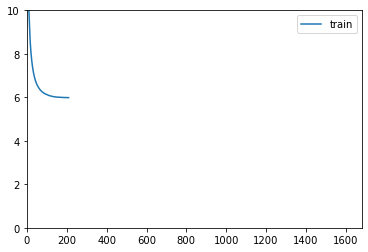

KeyboardInterrupt: 

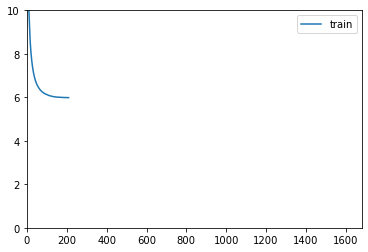

In [31]:
learn.fit(1, 1e-3) # learn.fit_one_cycle(1, 1e-2)

|experiment |epochs| train_loss| valid_loss |accuracy  | perplexity |time | notes                 |
|-----------|------|-----------|------------|----------|------------|-----|:---------------------:|
|     a     |  1   |19.061800  | 45.006886  | 0.090237 |     -      |09:10|          -            |
|     b     |  1   |5.943309   | 7.154285   | 0.090238 |1279.577148	|09:38| only predicts `xxmaj` |

Objetive (in 10 epochs) [video](https://youtu.be/vnOpEwmtFJ8?t=7549): train_loss=4.03 valid_loss=4.06 valid_accuracy=0.2867

### Test model

In [ ]:
learn.model(batch_x.cuda()) 

In [ ]:
batch_p = learn.model(batch_x.cuda()).cpu()
batch_p

In [ ]:
accuracy(new_batch_p, batch_y.cuda())

In [46]:
preds = new_batch_p.argmax(dim=-1)
preds

tensor([[7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        ...,
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7]], device='cuda:0')

In [50]:
preds.unique(return_counts=True)

(tensor([7], device='cuda:0'), tensor([4480], device='cuda:0'))

### Save model

In [ ]:
#torch.save(learn.model.state_dict(), './language_model.pth')

# <center> Model: AWD-LSTM

# Dropout layers

We divide the zeros&ones mask to **mantain the std** at applying the droput mask

In [14]:
def dropout_mask(x, size, drop_prob):
    return x.new(*size).bernoulli_(drop_prob).div_(drop_prob)

In [15]:
t = torch.rand(10,10)
mask = dropout_mask(t, (10,10), 0.1)
mask

tensor([[ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 10., 10.,  0.,  0.,  0., 10.,  0.],
        [10.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.]])

### `EmbeddingDropout` (aka `TokenDropout`)
- EmbeddingDropout applies dropout to the whole embedding matrix, to make the some rows equals zeros.
- THIS dropout is NOT APPLIEID ON THE OUTPUT of the embeding layer. TH dROP OUT IS APPLIED TO THE EMBEDDING WEITHS themselfs

In [54]:
input = torch.LongTensor([[0, 1, 2, 2, 1],
                          [0, 3, 2, 1, 2]])
input

tensor([[0, 1, 2, 2, 1],
        [0, 3, 2, 1, 2]])

In [58]:
emb = nn.Embedding(num_embeddings=100, embedding_dim=7, padding_idx=99) # For padding_idx will return a vector of zeros
out_emb = emb(input)
out_emb # [BS, SEQ_LEN, EMB_DIM]

tensor([[[-0.6585, -0.0951, -1.0614,  0.8276, -0.3901,  1.5006, -0.8054],
         [ 0.0229, -0.1936,  0.4089,  0.5277, -0.1738, -0.3447,  0.4222],
         [-0.9440,  0.7588,  0.0509, -1.0544, -0.6787, -2.0373, -0.0296],
         [-0.9440,  0.7588,  0.0509, -1.0544, -0.6787, -2.0373, -0.0296],
         [ 0.0229, -0.1936,  0.4089,  0.5277, -0.1738, -0.3447,  0.4222]],

        [[-0.6585, -0.0951, -1.0614,  0.8276, -0.3901,  1.5006, -0.8054],
         [ 0.0906,  0.6282,  1.3173,  0.0417, -0.1491, -0.4256,  0.0710],
         [-0.9440,  0.7588,  0.0509, -1.0544, -0.6787, -2.0373, -0.0296],
         [ 0.0229, -0.1936,  0.4089,  0.5277, -0.1738, -0.3447,  0.4222],
         [-0.9440,  0.7588,  0.0509, -1.0544, -0.6787, -2.0373, -0.0296]]],
       grad_fn=<EmbeddingBackward>)

In [76]:
dropout = torch.distributions.bernoulli.Bernoulli(0.3)
dropout.sample(sample_shape=(out_emb.shape[1], ))

tensor([1., 0., 1., 0., 1.])

In [70]:
(out_emb.shape[1], )

(5,)

In [61]:
torch.Bernoulli(0.3).sample((out.shape[1], ))

AttributeError: module 'torch' has no attribute 'Bernoulli'

In [ ]:
input = torch.LongTensor([[0, 1, 2, 2, 1],
                          [0, 3, 2, 1, 2]])

out = emb(input)
rw = Bernoulli(0.3).sample((out.shape[1], ))

out[:, rw==1].mean(dim=1)

In [36]:
tst_input = torch.randint(low=0, high=100, size=(5,))
tst_input

tensor([21, 32, 49, 61, 42])

In [37]:
enc(tst_input)

tensor([[-0.3420, -1.4190,  0.7275, -0.6516, -2.5164,  1.8570, -1.4382,  0.4643],
        [-0.8923, -0.3391, -0.3041, -1.3148,  1.4897,  0.1525,  1.4502,  0.0357],
        [-0.0545, -2.0934, -1.7578, -0.4612,  1.1825, -0.5089, -0.1025, -0.1985],
        [ 0.9805, -0.6491, -0.5569, -0.6984,  0.2961, -1.0677,  1.8033, -0.0987],
        [ 0.4785, -1.3237, -1.3687, -0.5233, -1.0823,  0.4919, -1.1676, -0.7927]],
       grad_fn=<EmbeddingBackward>)

In [39]:
d = nn.Dropout2d(p=.2)

In [53]:
d(enc(tst_input))

tensor([[-0.4275, -0.0000,  0.0000, -0.8145, -3.1455,  2.3213, -1.7978,  0.5804],
        [-0.0000, -0.4239, -0.3801, -0.0000,  1.8621,  0.1906,  0.0000,  0.0446],
        [-0.0682, -0.0000, -0.0000, -0.5765,  1.4781, -0.0000, -0.1282, -0.2481],
        [ 1.2256, -0.0000, -0.6961, -0.8730,  0.0000, -0.0000,  0.0000, -0.1234],
        [ 0.5982, -1.6546, -0.0000, -0.6541, -1.3528,  0.6148, -1.4595, -0.9909]],
       grad_fn=<MulBackward0>)

In [28]:
class EmbeddingDropout(nn.Module):
    
    def __init__(self, emb, embed_p):
        super().__init__()
        self.emb,self.embed_p = emb,embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1
 
    def forward(self, words, scale=None):
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0),1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            masked_embed = self.emb.weight * mask
        else:
            masked_embed = self.emb.weight
        if scale:
            masked_embed.mul_(scale)
        return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                           self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

In [29]:
enc = nn.Embedding(100, 7, padding_idx=1)
enc_dp = EmbeddingDropout(enc, 0.5)
tst_input = torch.randint(0,100,(8,))
tst_input, enc_dp(tst_input)

AttributeError: module 'torch.functional' has no attribute 'embedding'

### `RNNDropout` (aka `SequenceDropout`)
Dropout on the entire sequence dimension.

In [54]:
#export
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

### `WeightDropout`(aka `DropConnect`)
This is dropout not on the activations but **on the weights themselfs**.

In [59]:
import warnings

WEIGHT_HH = 'weight_hh_l0'

class WeightDropout(nn.Module):
    def __init__(self, module, weight_p=[0.], layer_names=[WEIGHT_HH]):
        super().__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args):
        self._setweights() # HERE WE APPLY DROPCONNECT
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)
        
DropConnect = WeightDropout

# Main model: `AWD_LSTM`
- The main model is a regular LSTM with several layers, but using all those kinds of dropouts.
- This is AWD-LSTM inspired by https://arxiv.org/abs/1708.02182.

In [ ]:
    input_size: The number of expected features in the input `x`
    hidden_size: The number of features in the hidden state `h`
    num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
        would mean stacking two LSTMs together to form a `stacked LSTM`,
        with the second LSTM taking in outputs of the first LSTM and
        computing the final results. Default: 1
    bias
    
    
[nn.LSTM(input_size  = emb_sz if l == 0 else n_hid,
         hidden_size = (n_hid if l != n_layers - 1 else emb_sz),
         num_layers  = 1,
         batch_first = True) for l in range(n_layers) ]

In [19]:
class AWDLSTM_body(nn.Module):
    
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token,
                 hidden_p=0.2,
                 input_p=0.6,
                 embed_dropout_prob  = 0.1, # aka TokenDropout
                 weight_dropout_prob = 0.5):
        
        super().__init__()
        
        self.bs,self.emb_sz,self.n_hid,self.n_layers = 1,emb_sz,n_hid,n_layers
        
        # Embeding
        self.emb    = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        emb_init_range = 0.1
        self.emb.weight.data.uniform_(-emb_init_range, emb_init_range)
        
        # LSTMs
        self.rnns = [nn.LSTM(input_size  = emb_sz if l == 0 else n_hid,
                             hidden_size = (n_hid if l != n_layers - 1 else emb_sz),
                             num_layers  = 1,
                             batch_first = True) for l in range(n_layers) ]
        
        # Dropouts
        self.emb_dp = EmbeddingDropout(self.emb, embed_dropout_prob)
        self.input_dp = RNNDropout(input_p)
        self.rnns = nn.ModuleList([WeightDropout(rnn, weight_dropout_prob) for rnn in self.rnns])
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input):
        bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(self.emb_dp(input))
        new_hidden,raw_outputs,outputs = [],[],[]
        
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output) 
        self.hidden = to_detach(new_hidden)
        return raw_outputs, outputs
    
    def to_detach(h):
        "Detaches `h` from its history."
        return h.detach() if type(h) == torch.Tensor else tuple(to_detach(v) for v in h)

    def _one_hidden(self, l):
        "Return one hidden state."
        nh = self.n_hid if l != self.n_layers - 1 else self.emb_sz
        return next(self.parameters()).new(1, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]


class AWDLSTM_linearHead(nn.Module):
    def __init__(self, n_out, n_hid, output_p, tie_encoder=None, bias=True):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight
        else: init.kaiming_uniform_(self.decoder.weight)

    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1]).contiguous()
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded, raw_outputs, outputs